# Detecção de Apnéia de Sono por Áudio

<a href="https://colab.research.google.com/github/fabiobento/edge-ml/blob/main/audio/simple_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Configuração

Importe os módulos e as dependências necessárias. Você usará o [`tf.keras.utils.audio_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/audio_dataset_from_directory) (introduzido no TensorFlow 2.10), que ajuda a gerar conjuntos de dados de classificação de áudio a partir de diretórios de arquivos `.wav`. Você também precisará do [seaborn](https://seaborn.pydata.org) para visualização.

In [1]:
!pip install soundfile

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import pathlib

import soundfile as sf

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Defina o valor inicial para a reprodutibilidade do experimento.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-10-29 20:06:14.119186: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 20:06:14.128882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 20:06:14.139724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 20:06:14.142859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 20:06:14.150987: I tensorflow/core/platform/cpu_feature_guar

## Importar o conjunto de dados

In [3]:
try:
    import google.colab
    IN_COLAB = True
    print("Executando no Google Colab")
except ImportError:
    IN_COLAB = False
    print("Não executando no Google Colab")

Não executando no Google Colab


In [4]:
if IN_COLAB:
  # Baixar arquivo do conjunto de dados 
  %pip install gdown
  !mkdir -p ./datasets
  !gdown --id 1BsQkFUymQwcG1m4KGPWgRn0ZVI5oGbZV -O ./datasets/snoring-dataset.zip
  
  !unzip -n -q ./datasets/snoring-dataset.zip
  data_dir = '/content/snoring-dataset'
else:
    data_dir = '/workspace/audio/datasets/snoring-dataset'

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['normal' 'Snoring_dataset.txt' 'ronco']


Divididos em diretórios dessa forma, você pode carregar facilmente os dados usando [`tf.keras.utils.audio_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/audio_dataset_from_directory).

Os clipes de áudio são de aproximadamente 1 segundo ou menos a 16kHz. A opção `output_sequence_length=16000` compacta os clipes mais curtos em exatamente 1 segundo (e corta os mais longos) para que possam ser facilmente agrupados.

In [6]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,    
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


I0000 00:00:1730232375.274175   21503 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730232375.281562   21503 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730232375.284832   21503 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730232375.288762   21503 cuda_executor.cc:1015] successful NUMA node read from SysFS ha


label names: ['normal' 'ronco']


O conjunto de dados agora contém lotes de clipes de áudio e rótulos inteiros. Os clipes de áudio têm uma forma de `(lote, amostras, canais)`.

In [7]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [8]:
val_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

Esse conjunto de dados contém apenas áudio de canal único, portanto, use a função `tf.squeeze` para eliminar o eixo extra:

In [9]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [10]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [11]:
val_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

A função `utils.audio_dataset_from_directory` retorna apenas até duas divisões. É uma boa ideia manter um conjunto de teste separado do conjunto de validação.

O ideal é mantê-lo em um diretório separado, mas, nesse caso, é possível usar `Dataset.shard` para dividir o conjunto de validação em duas metades.

Observe que a iteração sobre **qualquer** fragmento carregará **todos** os dados e manterá apenas sua fração.

In [12]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [13]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


2024-10-29 20:06:16.171022: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Vamos plotar algumas formas de onda de áudio:

In [14]:
label_names[[1,1,0,0]]

array(['ronco', 'ronco', 'normal', 'normal'], dtype='<U6')

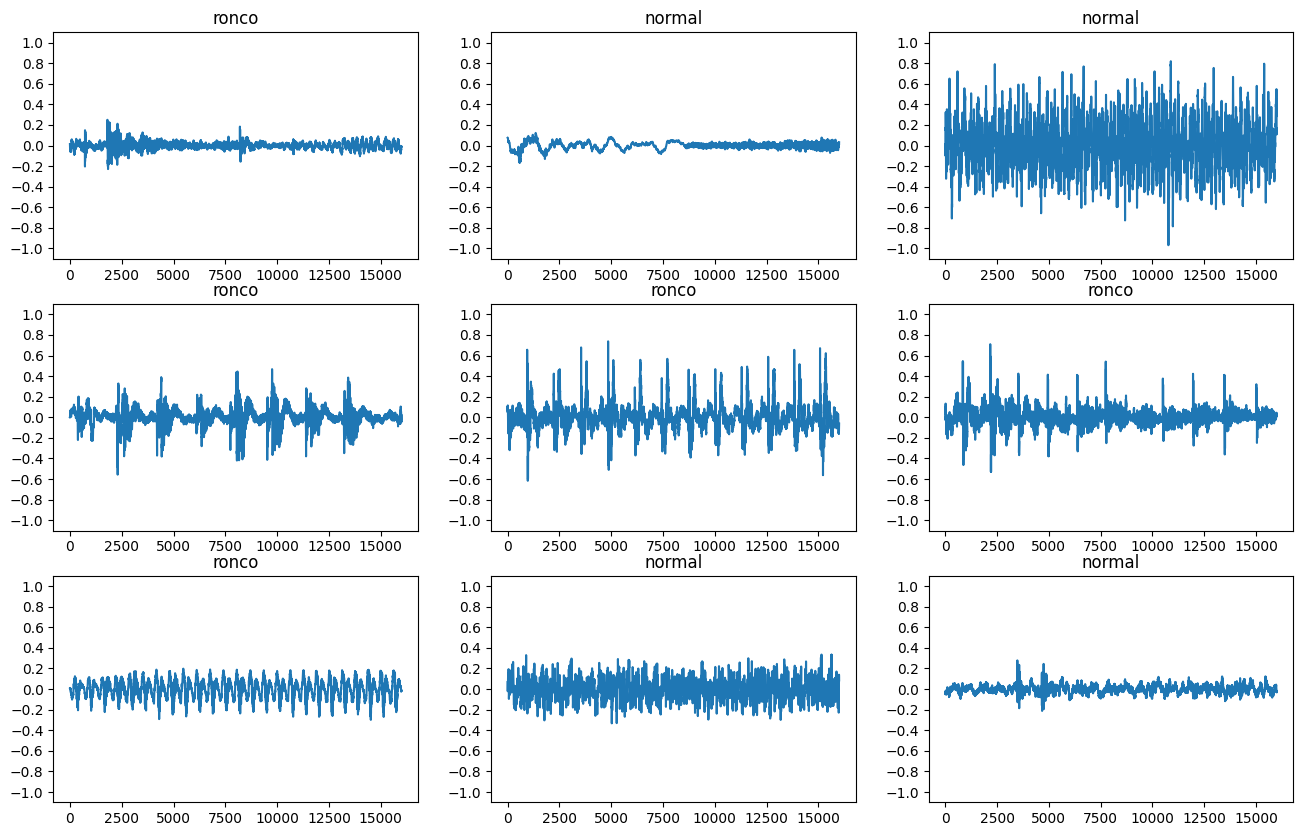

In [15]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Converter formas de onda em espectrogramas

As formas de onda no conjunto de dados são representadas no domínio do tempo. Em seguida, você transformará as formas de onda dos sinais no domínio do tempo em sinais no domínio do tempo-frequência, calculando a [transformada de Fourier de curto prazo (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) para converter as formas de onda em [espectrogramas](https://en.wikipedia.org/wiki/Spectrogram), que mostram as alterações de frequência ao longo do tempo e podem ser representadas como imagens 2D. Você alimentará as imagens do espectrograma em sua rede neural para treinar o modelo.

Uma transformada de Fourier (`tf.signal.fft`) converte um sinal em suas frequências componentes, mas perde todas as informações de tempo. Em comparação, o STFT (`tf.signal.stft`) divide o sinal em janelas de tempo e executa uma transformada de Fourier em cada janela, preservando algumas informações de tempo e retornando um tensor 2D no qual você pode executar convoluções padrão.

Crie uma função utilitária para converter formas de onda em espectrogramas:

- As formas de onda precisam ter o mesmo comprimento, de modo que, ao convertê-las em espectrogramas, os resultados tenham dimensões semelhantes. Isso pode ser feito simplesmente com o preenchimento zero dos clipes de áudio com menos de um segundo (usando `tf.zeros`).
- Ao chamar `tf.signal.stft`, escolha os parâmetros `frame_length` e `frame_step` de forma que a “imagem” do espectrograma gerado seja quase quadrada. Para obter mais informações sobre a escolha dos parâmetros do STFT, consulte [este vídeo do Coursera] (https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) sobre processamento de sinais de áudio e STFT.
- A STFT produz uma matriz de números complexos que representam a magnitude e a fase. Entretanto, neste tutorial, você usará apenas a magnitude, que pode ser obtida aplicando `tf.abs` na saída de `tf.signal.stft`.

In [16]:
def get_spectrogram(waveform):
  # Converta a forma de onda em um espectrograma por meio de um STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtenha a magnitude do STFT.
  spectrogram = tf.abs(spectrogram)
  # Adicione uma dimensão de “canais” para que o espectrograma possa ser usado
  # como dados de entrada semelhantes a imagens com camadas de convolução (que esperam
  # forma (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Em seguida, comece a explorar os dados. Imprima as formas da forma de onda tensorizada de um exemplo e o espectrograma correspondente e reproduza o áudio original:

In [17]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: ronco
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: normal
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: normal
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Agora, defina uma função para exibir um espectrograma:

In [18]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Converta as frequências em escala logarítmica e transponha, de modo que o tempo seja
  # representado no eixo x (colunas).
  # Adicione um epsilon para evitar tomar um log de zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Trace a forma de onda do exemplo ao longo do tempo e o espectrograma correspondente (frequências ao longo do tempo):

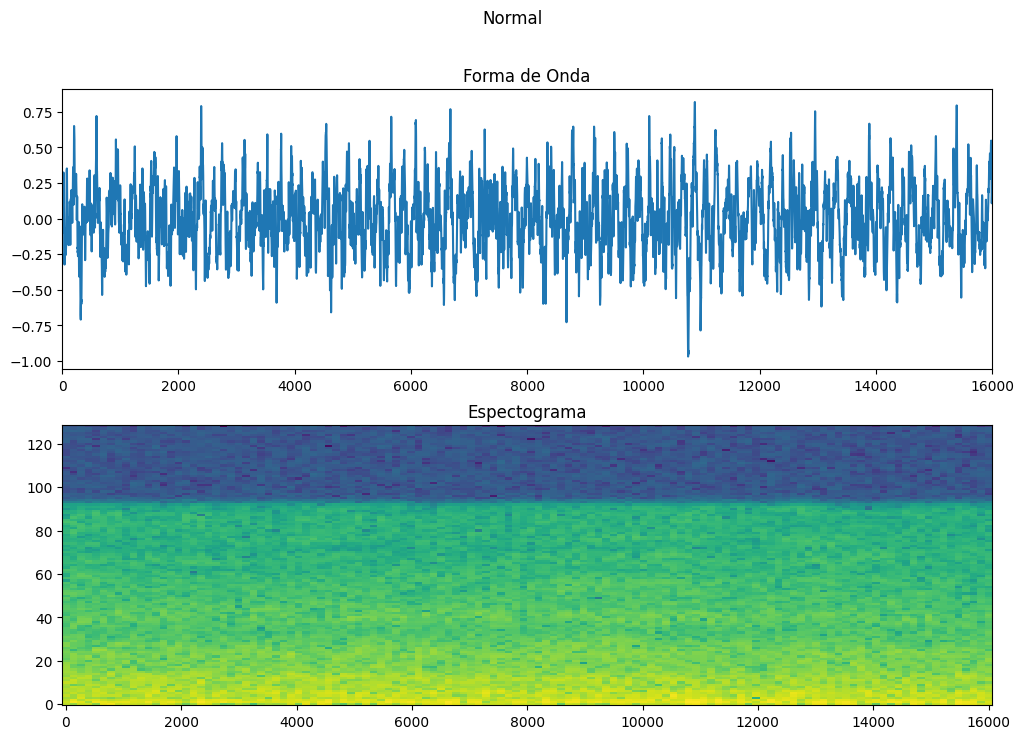

In [35]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Forma de Onda')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Espectograma')
plt.suptitle(label.title())
plt.show()

Agora, crie conjuntos de dados de espectrograma a partir dos conjuntos de dados de áudio:

In [20]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine os espectrogramas de diferentes exemplos do conjunto de dados:

In [22]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

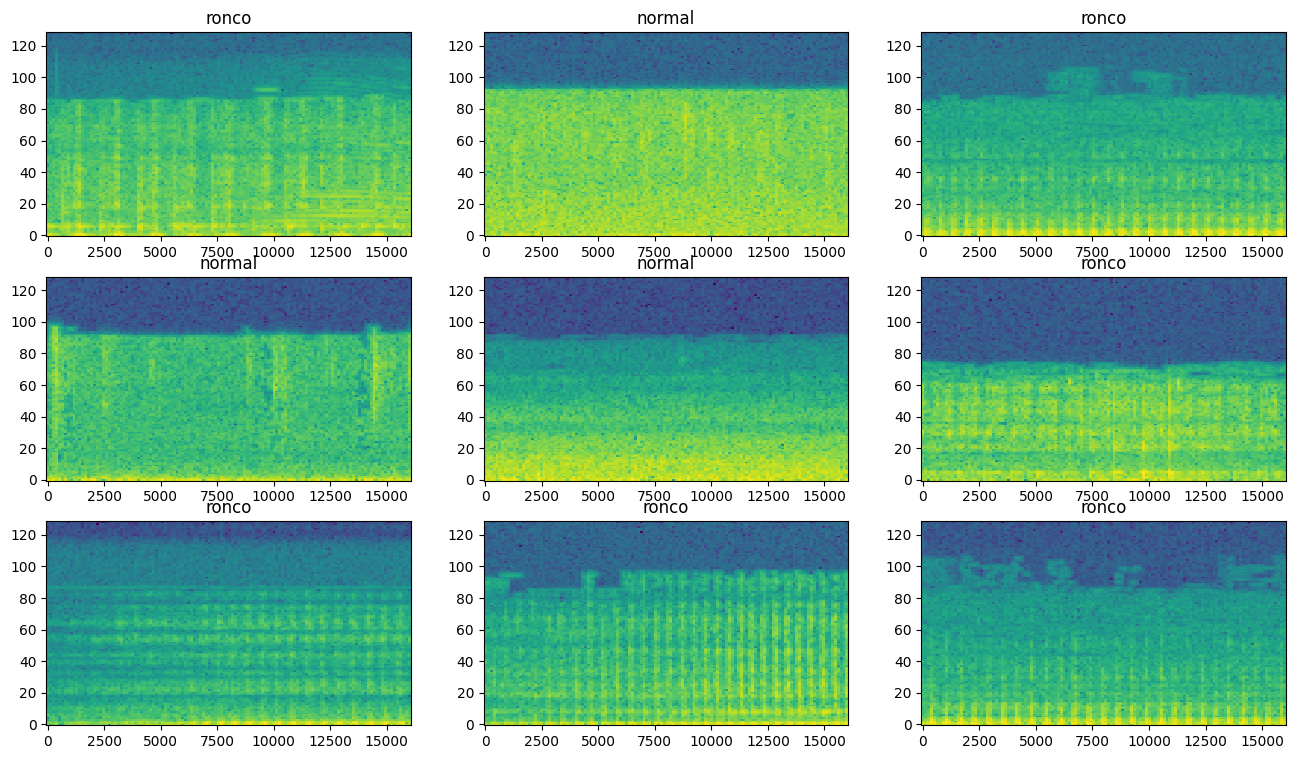

In [23]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Criar e treinar o modelo

Adicione as operações `Dataset.cache` e `Dataset.prefetch` para reduzir a latência de leitura durante o treinamento do modelo:

In [24]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Para o modelo, você usará uma rede neural convolucional (CNN) simples, já que transformou os arquivos de áudio em imagens de espectrograma.

Seu modelo `tf.keras.Sequential` usará as seguintes camadas de pré-processamento do Keras:

- `tf.keras.layers.Resizing`: para reduzir a amostragem da entrada e permitir que o modelo seja treinado mais rapidamente.
- `tf.keras.layers.Normalization`: para normalizar cada pixel na imagem com base em sua média e desvio padrão.

Para a camada `Normalization`, seu método `adapt` precisaria primeiro ser chamado nos dados de treinamento para calcular as estatísticas agregadas (ou seja, a média e o desvio padrão).

In [25]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instanciar a camada `tf.keras.layers.Normalization`.
norm_layer = layers.Normalization()
# Ajuste o estado da camada aos espectrogramas
# com `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Reduzir a amostragem da entrada.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


2024-10-29 20:06:18.151648: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,837 (6.20 MB)

 Trainable params: 1,624,834 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Treine o modelo em 10 épocas para fins de demonstração:

In [27]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


I0000 00:00:1730232378.769225   21616 service.cc:146] XLA service 0x7c59b001c8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730232378.769244   21616 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-10-29 20:06:18.784726: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 20:06:18.872581: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6344 - loss: 0.6056

I0000 00:00:1730232380.859682   21616 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6371 - loss: 0.6027 - val_accuracy: 0.7396 - val_loss: 0.4101
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7995 - loss: 0.3751 - val_accuracy: 0.7865 - val_loss: 0.3564
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8513 - loss: 0.2843 - val_accuracy: 0.8229 - val_loss: 0.3364
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8752 - loss: 0.2588 - val_accuracy: 0.8438 - val_loss: 0.2678
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9002 - loss: 0.2048 - val_accuracy: 0.8542 - val_loss: 0.2643
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9103 - loss: 0.1976 - val_accuracy: 0.8906 - val_loss: 0.2202
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9179 - loss: 0.1765 - val_accuracy: 0.8906 - val_loss: 0.2095
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9185 - loss: 0.1765 - val_accuracy: 0.8854 - val_loss: 0.2093
Ep

Vamos traçar as curvas de perda de treinamento e validação para verificar como seu modelo melhorou durante o treinamento:

Text(0, 0.5, 'Acurácia [%]')

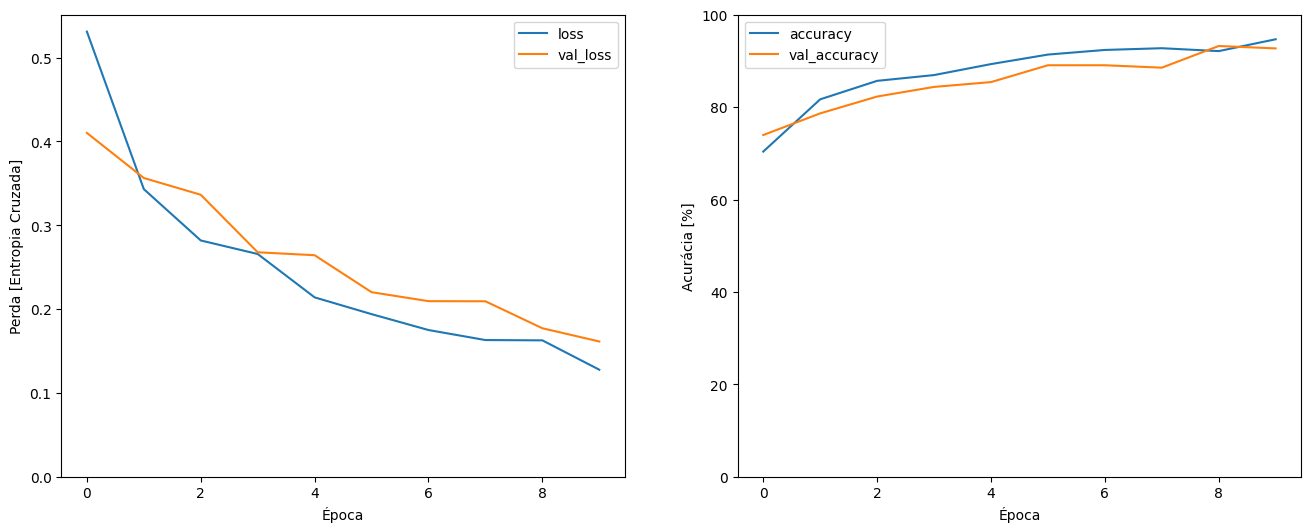

In [37]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Época')
plt.ylabel('Perda [Entropia Cruzada]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Época')
plt.ylabel('Acurácia [%]')

## Avaliar o desempenho do modelo

Execute o modelo no conjunto de teste e verifique o desempenho do modelo:

In [29]:
model.evaluate(test_spectrogram_ds, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 457ms/step - accuracy: 0.9502 - loss: 0.1558


{'accuracy': 0.9471153616905212, 'loss': 0.1534988135099411}

### Exibir uma matriz de confusão

Use uma [matriz de confusão](https://developers.google.com/machine-learning/glossary#confusion-matrix) para verificar o desempenho do modelo na classificação de cada um dos comandos no conjunto de teste:

In [30]:
y_pred = model.predict(test_spectrogram_ds)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


In [31]:
y_pred = tf.argmax(y_pred, axis=1)

In [32]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

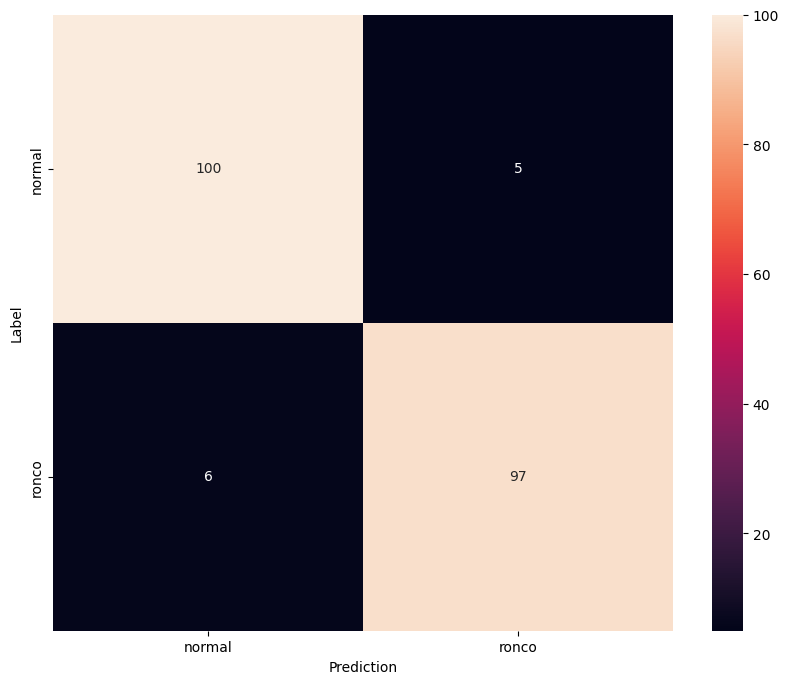

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Execute a inferência em um arquivo de áudio

Por fim, verifique o resultado da previsão do modelo usando um arquivo de áudio de entrada de alguém roncando”. Qual é o desempenho do seu modelo?

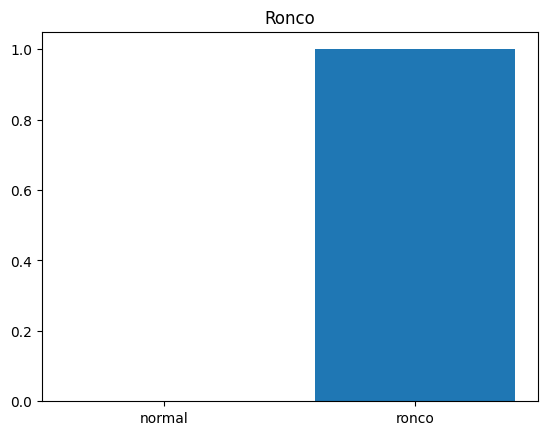

In [39]:
if IN_COLAB:
  x = '/content/snoring-dataset/ronco/1_8.wav'
else:
  x ='/workspace/audio/datasets/snoring-dataset/ronco/1_8.wav'


x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['normal', 'ronco']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Ronco')
plt.show()

display.display(display.Audio(waveform, rate=16000))

## Exportar o modelo com pré-processamento

O modelo não é muito fácil de usar se você tiver que aplicar essas etapas de pré-processamento antes de passar os dados para o modelo para inferência. Portanto, crie uma versão de ponta a ponta:

In [40]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Aceita um nome de arquivo de cadeia de caracteres ou um lote de formas de onda.
    # Você pode adicionar assinaturas adicionais para uma única onda ou um lote irregular.
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # Se eles passarem uma string, carregue o arquivo e decodifique-o.
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Execute o teste do modelo de “exportação”:

In [41]:
if IN_COLAB:
  x = '/content/snoring-dataset/ronco/1_8.wav'
else:
  x ='/workspace/audio/datasets/snoring-dataset/ronco/1_8.wav'

export = ExportModel(model)
export(tf.constant(str(x)))

{'predictions': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-8.251452, 10.741443]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'ronco'], dtype=object)>}

Salve e recarregue o modelo; o modelo recarregado apresenta resultados idênticos:

In [42]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved/assets


INFO:tensorflow:Assets written to: saved/assets


{'predictions': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-8.251452, 10.741443]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'ronco'], dtype=object)>}

## Próximas etapas

Este tutorial demonstrou como realizar a classificação simples de áudio/reconhecimento automático de fala usando uma rede neural convolucional com TensorFlow e Python. Para saber mais, considere os seguintes recursos:

- O tutorial [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) mostra como usar a aprendizagem por transferência para classificação de áudio.
- Os notebooks do [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- O tutorial
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) ensina como criar seu próprio aplicativo da Web interativo para classificação de áudio.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) no arXiv.
- O TensorFlow também tem suporte adicional para [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) para ajudar em seus próprios projetos baseados em áudio.
- Considere usar a biblioteca [librosa](https://librosa.org/) para análise de música e áudio.